In [ ]:
%matplotlib inline
%run ../setup/nb_setup

# Science Case Studies: Selecting Stars from Gaia-Sausage-Enceladus

Author(s): Emily Cunningham


## Introduction

In this workshop, we are going to be exploring some observational data and learning how different studies have selected and characterized the so-called "Gaia-Sausage-Enceladus" (hereafter GSE; Belokurov et al. 2018, Helmi et al. 2018). GSE is argued to be the dominant contributor by mass to the Milky Way's inner halo (~<20 kpc). 


### Notebook Setup and Package Imports

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join 
from matplotlib.colors import LogNorm
#IMPORT YOUR FAVORITE PACKAGE FOR CONVERTING VELOCITIES TO ORBITAL PARAMETERS HERE

In [54]:
#To make figures pretty; feel free to change based on your aesthetic preferences!
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.family"]='Serif'
rcParams["font.size"]=12

## Step 1. Grab the data! 

For this workshop, we will be making use of GALAH DR3 (Buder et al. 2020) to explore the properties of the Gaia-Sausage-Enceladus. 

The first step is go download the data! Go find and download the main GALAH DR3 catalog [here](https://www.galah-survey.org/dr3/the_catalogues/)

In [7]:
#Put the path on your machine to the GALAH main DR3 file here!
galah_filename='GALAH_DR3_main_allstar_v2.fits'

Next, we want to read in the data, and load in into a form which we can manipulate easily. Because this is a .fits file, reading in the data with [Astropy.io](https://docs.astropy.org/en/stable/io/fits/index.html) is usually the simplest course of action. Once we open the file, we can load the data into an [Astropy Table.](https://docs.astropy.org/en/stable/table/index.html#using-table) 

In [12]:
#In this cell, write code to read in this file using astropy.io.fits, and load it into an Astropy table. 
hdu=fits.open(galah_filename)
galah_main=Table(hdu[1].data)

In [14]:
#Print the column names and the number of entries
print(galah_main.columns)
print(len(galah_main))

<TableColumns names=('star_id','sobject_id','dr2_source_id','dr3_source_id','survey_name','field_id','flag_repeat','wg4_field','wg4_pipeline','flag_sp','teff','e_teff','irfm_teff','irfm_ebv','irfm_ebv_ref','logg','e_logg','fe_h','e_fe_h','flag_fe_h','fe_h_atmo','vmic','vbroad','e_vbroad','chi2_sp','alpha_fe','e_alpha_fe','nr_alpha_fe','flag_alpha_fe','flux_A_Fe','chi_A_Fe','Li_fe','e_Li_fe','nr_Li_fe','flag_Li_fe','C_fe','e_C_fe','nr_C_fe','flag_C_fe','O_fe','e_O_fe','nr_O_fe','flag_O_fe','Na_fe','e_Na_fe','nr_Na_fe','flag_Na_fe','Mg_fe','e_Mg_fe','nr_Mg_fe','flag_Mg_fe','Al_fe','e_Al_fe','nr_Al_fe','flag_Al_fe','Si_fe','e_Si_fe','nr_Si_fe','flag_Si_fe','K_fe','e_K_fe','nr_K_fe','flag_K_fe','Ca_fe','e_Ca_fe','nr_Ca_fe','flag_Ca_fe','Sc_fe','e_Sc_fe','nr_Sc_fe','flag_Sc_fe','Sc2_fe','e_Sc2_fe','nr_Sc2_fe','flag_Sc2_fe','Ti_fe','e_Ti_fe','nr_Ti_fe','flag_Ti_fe','Ti2_fe','e_Ti2_fe','nr_Ti2_fe','flag_Ti2_fe','V_fe','e_V_fe','nr_V_fe','flag_V_fe','Cr_fe','e_Cr_fe','nr_Cr_fe','flag_Cr_fe','C

We can see that GALAH DR3 contains information for 30+ abundances. Cool! We can see that this catalog also contains information about the stars kinematics from Gaia DR2. It would be more fun to use the most recent measurements from Gaia eDR3. Fortunately for us, the GALAH team has released a catalog cross-matching their sources with Gaia eDR3. Go grab it from the GALAH catalog page! It is called GALAH_DR3_VAC_GaiaEDR3_v2.fits 

In [15]:
#Again modify path here to location on your machine!
galah_gaiaedr3_filename='GALAH_DR3_VAC_GaiaEDR3_v2.fits'

In [17]:
#Read this new file and put it into a new table 
hdu=fits.open(galah_gaiaedr3_filename)
galah_gaiaedr3=Table(hdu[1].data)

In [20]:
#Print the column names and the number of entries
print(galah_gaiaedr3.columns)
print(len(galah_gaiaedr3))

<TableColumns names=('star_id','sobject_id','dr2_source_id','dr3_source_id','angular_distance','magnitude_difference','proper_motion_propagation','solution_id','designation','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pm','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','nu_eff_used_in_astrometry','pseudocolour','pseudocolour_error','ra_pseudocolour_corr','dec_pseudocolour_corr','parallax_pseudocolour_corr','pmra_pseudocolour_corr','pmdec_pseudocolour_corr','astrometric_matched_transits','visibility

Great! We now have the latest astrometric measurements for these stars. However, this catalog doesn't have any of the spectroscopic measurements for the stars; we will have to combine information from these two tables. Furthermore, you may notice that there are MORE entries in the GALAH-Gaia eDR3 catalog than in the GALAH main catalog. Therefore, we have to be careful when combining information from these two tables.

In the cell below, match the two tables using the "join" function in Astropy.

In [21]:
joined_tab=join(galah_main, galah_gaiaedr3, keys='sobject_id')
print(len(joined_tab))

588571


Great! Now that we have one big table with all the chemical and kinematic information for every star, we can get started on visualizing and analyzing the data. 

## Step 2. Select a Sample of Giants

Let's start by making an HR Diagram, and select a population of giants to use for the rest of this workshop.

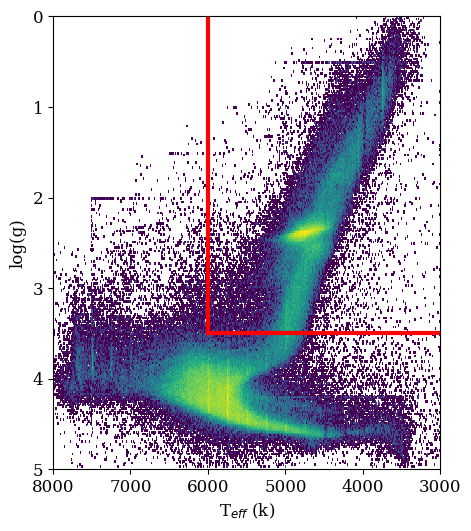

In [55]:
plt.figure(figsize=(5,6))
plt.hist2d(joined_tab['teff'],joined_tab['logg'], bins=( np.arange(3000,8000,6),np.arange(0,5, 0.02)), norm=LogNorm())
plt.ylim(5,0)
plt.xlim(8000, 3000)
plt.ylabel('log(g)')
plt.xlabel(r'T$_{eff}$ (k)')

#Using the HR diagram, select a subsample of giants. Overplot your selection box.
giants=(joined_tab['teff']<6000.)&(joined_tab['logg']<3.5)
plt.plot([6000,6000], [3.5, 0], color='r', linewidth=3)
plt.plot([3000,6000], [3.5, 3.5], color='r', linewidth=3)

Finally, for the purposes of this exercise, we want to make sure we don't have any NaNs in our sample for the distances. So we are going to apply a quality cut on the parallaxes as well: 

In [128]:
print(np.min(joined_tab['parallax']), np.max(joined_tab['parallax']))

par=joined_tab['parallax']
par_err=joined_tab['parallax_error']
plx_snr = par/ par_err
keep = ((plx_snr > 5) & (np.isfinite(joined_tab['rv_galah'])))
print(np.sum(keep))
print(np.sum(giants&keep))


nan nan
565209
178208


## Step 3. Kinematics

Now, let's start looking at the kinematics of our sample!

First, use astropy.coordinates and the Gaia/GALAH measurements to compute Galactocentric velocities. From here on out, let's limit our sample to the giants that pass our parallax quality cuts. 

In [69]:
#Compute velocities in the Galactocentric frame here
c=coord.SkyCoord(ra=joined_tab['ra'][giants&keep]*u.deg, dec=joined_tab['dec'][giants&keep]*u.deg, \
                 radial_velocity=joined_tab['rv_galah'][giants&keep]*u.km/u.s, \
                pm_ra_cosdec=joined_tab['pmra'][giants&keep]*u.mas/u.yr, \
                 pm_dec=joined_tab['pmdec'][giants&keep]*u.mas/u.yr, 
                distance=1./joined_tab['parallax'][giants&keep]*u.kpc)

galcen=c.transform_to(coord.Galactocentric)

In [70]:
print(galcen.v_y.value)

[166.98513854 171.0646272   94.29878423 ... 210.92701458 153.69100094
 194.78422505]


Now that we've converted to the Galactocentric frame, let's compute velocities in both spherical and cylindrical coordinates.

In [73]:
#Compute the cylindrical and spherical galactocentric velocities  

r=(galcen.x.value**2+galcen.y.value**2+galcen.z.value**2)**(1./2.)
Rp=(galcen.x.value**2+galcen.y.value**2)**(1./2.)

#Spherical
Vr = galcen.x.value*galcen.v_x.value/r +galcen.y.value*galcen.v_y.value/r +galcen.z.value*galcen.v_z.value/r
Vphi = galcen.y.value*galcen.v_x.value/Rp -galcen.x.value*galcen.v_y.value/Rp
Vtheta = galcen.z.value*galcen.x.value*galcen.v_x.value/(Rp*r) +galcen.z.value*galcen.y.value*galcen.v_y.value/(Rp*r)\
        -Rp*galcen.v_z.value/r

#Cylindrical
galcen.set_representation_cls('cylindrical')
vR = galcen.d_rho.to(u.km/u.s)
vphi = (galcen.rho * galcen.d_phi).to(u.km/u.s, u.dimensionless_angles())
vz = galcen.d_z.to(u.km/u.s)

vRz = np.sqrt(vR**2 + vz**2)

Let's plot a Toomre diagram quickly to make sure all looks reasonable. The Toomre diagram has historically been used to separate the different kinematic components of the Galaxy (i.e., thin disk, thick disk, and halo). A Toomre diagram compares the rotational speed of a star with its total velocity in the other two components of motion. Historically, this diagram was usually shown in Galactocentric cartesian coordinates $(U,V,W)$, where it was assumed that $V$ was equivalent to the rotational velocity of the disk. While this is approximately true in the solar neighborhood, we now have measured velocities for stars at larger distances from our Sun, where $V\neq v_{\phi}$. Therefore, here we will plot our Toomre diagram in cylindrical coordinates.

If all has gone well in computing the Galactocentric velocity, you should see a high density region near the average circular velocity of the disk. Indicate on the Toomre Diagram the approximate locations of the thin disk, thick disk and halo

Text(0, 0.5, 'v${_{RZ}}$ (km/s)')

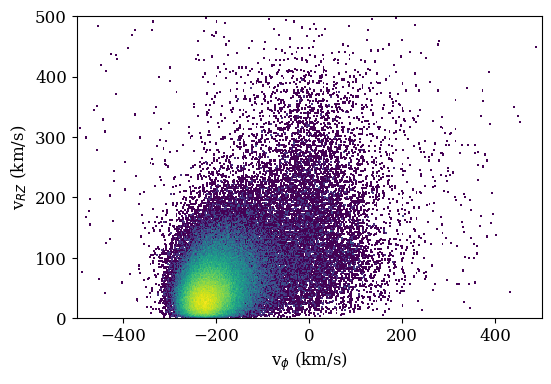

In [58]:
plt.hist2d(vphi.value, vRz.value, bins=(np.arange(-500, 500+1e-3, 2),
                np.arange(0, 500+1e-3, 2)),
          norm=LogNorm());
plt.xlabel(r'v${_\phi}$ (km/s)')
plt.ylabel(r'v${_{RZ}}$ (km/s)')
#Indicate the approximate locations in this diagram for thin disk, thick disk and halo.

We can also make the "Sausage" plot (from Belokurov et al. 2018): in this paper, they compared the rotational velocity distributions with the radial velocity distributions.

In the below plot, you should again see a high density region corresponding to the disk. You should also see a population that has an extended radial velocity distribution but a narrower rotational velocity distribution. This is the so-called "Sausage."


Text(0.5, 0, 'V$_{R}$ (km/s)')

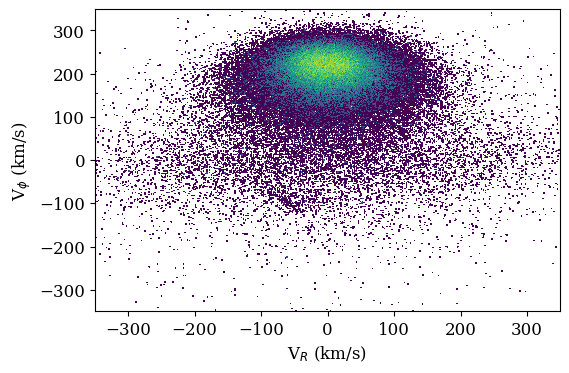

In [129]:
#Indicate the Disk and the "Sausage" in the below figure!
plt.hist2d(Vr,Vphi, bins=np.arange(-350,350), norm=LogNorm());
plt.ylabel(r'V$_{\phi}$ (km/s)')
plt.xlabel('V$_{R}$ (km/s)')

Now, using your method of choice, compute the following:

1) Orbital Energy 

2) Actions ($J_R, L_z, J_{z}$) 

3) Eccentricity  

4) Apocenter radius

Feel free to use gala or galpy to compute these quantities! Either way, be sure to use a Milky Way potential model ([MilkyWayPotential](http://gala.adrian.pw/en/latest/api/gala.potential.potential.MilkyWayPotential.html) in gala or [McMillan17](https://docs.galpy.org/en/v1.6.0/reference/potential.html#potential-mw) in galpy). 

If computing these quantities in galpy, please using the Staeckel approximation (actionAngleStaeckel) with a focus on 0.45. Within actionAngleStaeckel, useful functions include calcELStaeckel, actionsFreqsAngles, and EccZmaxRperiRap.

A few things to note using galpy:

* Coordinate systems here: galpy uses a _left-handed_ coordinate system, meaning that the rotational velocity of the disk is positive. This is likely the OPPOSITE of the rotational velocity you computed above.

* Units: distances are in units of $R_{sun}$ and velocities in units of $V_{sun}$. So, for example, once you compute the Energy (which has units of $(km/s)^2$), you'll want to multiply the value you get from galpy by ($V_{sun}^2$). 

## ADRIAN: Useful suggestions of how to do this in gala instead? 

Hint: you may have noticed that the GALAH team has computed a table with these quantities already (using galpy), in an available VAC on their website. You can also see there all choices that they made when computing actions, angles, etc. If you get really stuck, you can always grab the catalog (match it to your sample) if you want to move on with the exercise :)

In [64]:
#COMPUTE ACTIONS AND ORBITAL PARAMETERS HERE.

#Note for the organizers/Adrian: I (Emily) am going to be lazy here and just read in the VAC. 
# But am intending for the students to calculate these themselves
hdu3=fits.open('GALAH_DR3_VAC_dynamics_v2.fits')
dynamics_data=hdu3[1].data
dynamics_tab=Table(dynamics_data)
full_tab=join(joined_tab, dynamics_tab, keys='sobject_id')

In [67]:
#Put your final values here, in the correct physical units 
#(i.e., energy in units of (km/s)^2, actions in kpc (km/s), etc.)
energy=full_tab['Energy'][giants&keep]
Jr=full_tab['J_R'][giants&keep]
Lz=full_tab['L_Z'][giants&keep]
Jz=full_tab['J_Z'][giants&keep]
ecc=full_tab['ecc'][giants&keep]
r_apo=full_tab['R_ap'][giants&keep]

## Step 4. Exploring the properties of the Gaia-Enceladus-Sausage with different selections. 

Now that we have our orbital properties, we are going to take a look at how different groups have "identified" stars as belonging to the GES, and compare their properties. 

Have a look at the following papers and how they identify GES stars:

1) [Helmi et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018Natur.563...85H/abstract) (see Figure 1)

2) [Feuillet et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021arXiv210512141F/abstract) (see Section 3.1)

3) [Naidu et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...901...48N/abstract) (see their Figure 11; don't worry about subtracting off the other components for this exercise!)

In [107]:
#After looking at the papers, enter the selection criteria for each of the studies here:
helmi=(Lz<150.)&(Lz>-1500.)&(energy>-1.8e5)
feuillet=(np.sqrt(full_tab['J_R'][giants&keep])<55)&(np.sqrt(full_tab['J_R'][giants&keep])>30)&\
    (np.abs(full_tab['L_Z'][giants&keep])<500)
naidu=ecc>0.7

We are now going to compare these different selections, and investigate how our inferences about the GES might vary given a selection function. 

We are going to use the below plots as a baseline:

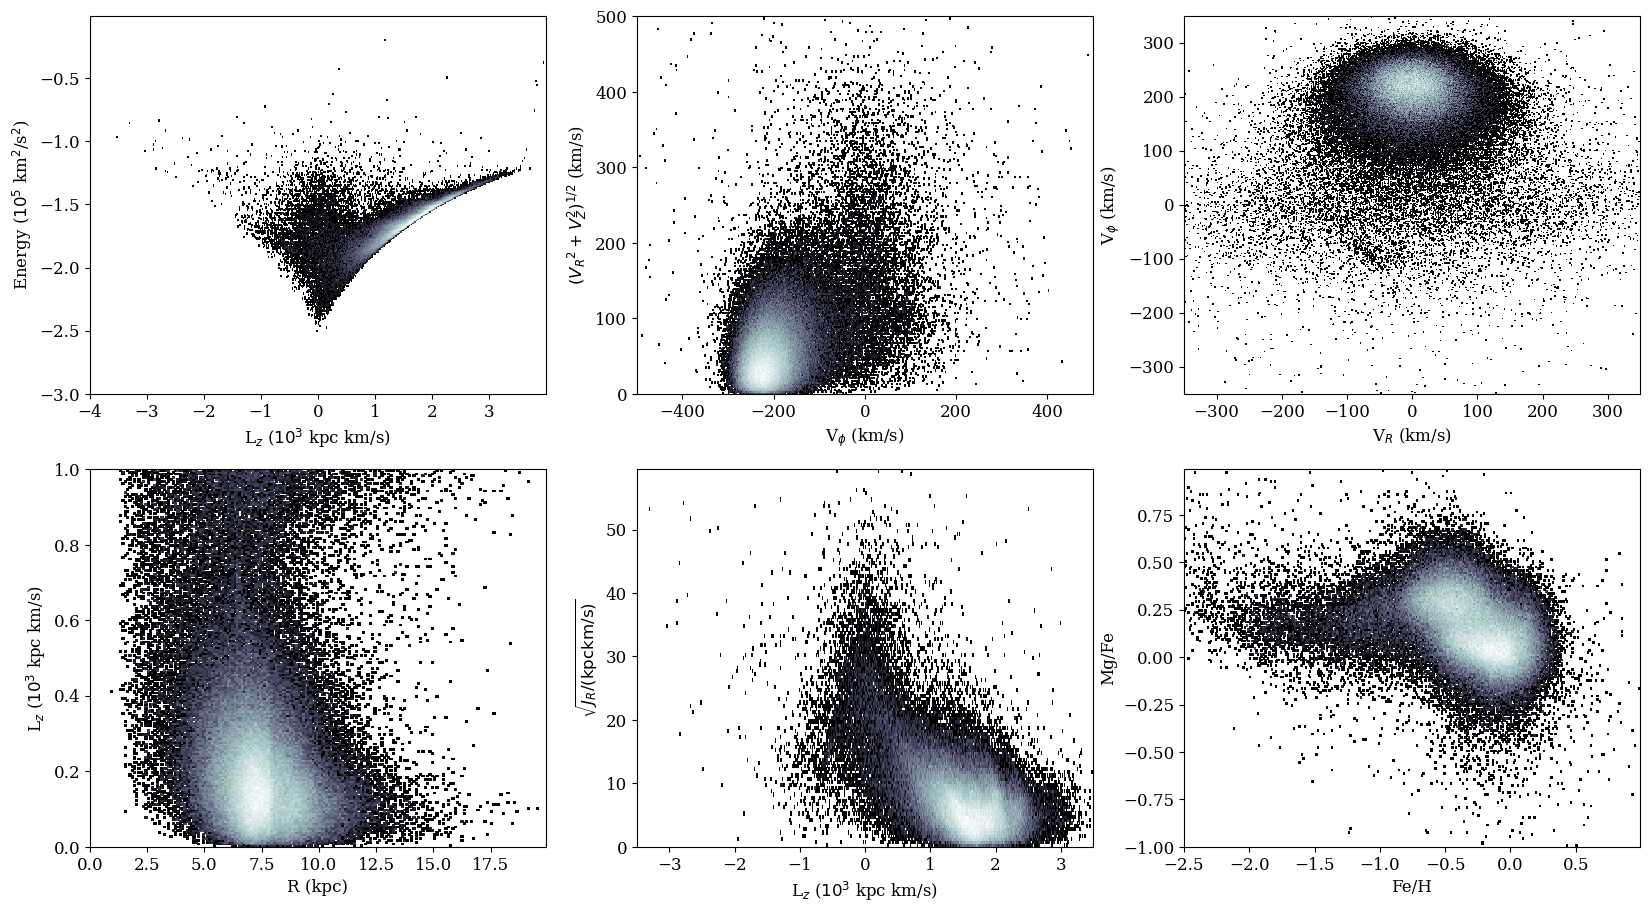

In [125]:
f, ax=plt.subplots(2,3, figsize=(20,11))

ax[0,0].hist2d(Lz/1000.,energy/1.e5, \
           bins=(np.arange(-4,4,.01), np.arange(-3., 0, 0.01)), norm=LogNorm(), cmap='bone');
ax[0,0].set_ylabel(r"Energy ($10^5$ km$^2$/s$^2$)")
ax[0,0].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")

ax[0,1].hist2d(vphi.value, vRz.value,\
           bins=(np.arange(-500, 500+1e-3, 2),
                np.arange(0, 500+1e-3, 2)),
          norm=LogNorm(), cmap='bone');
ax[0,1].set_xlabel(r'V$_{\phi}$ (km/s)')
ax[0,1].set_ylabel(r'$(V{_R}^2+V_Z^2)^{1/2}$ (km/s)')

ax[0,2].hist2d(Vr,Vphi, bins=np.arange(-350,350), norm=LogNorm(), cmap='bone');
ax[0,2].set_ylabel(r'V$_{\phi}$ (km/s)')
ax[0,2].set_xlabel('V$_{R}$ (km/s)')

ax[1,0].hist2d(r,ecc, bins=(np.arange(0,20,0.1), np.arange(0,1.001,0.005)), norm=LogNorm(), cmap='bone');
ax[1,0].set_xlabel('R (kpc)')
ax[1,0].set_ylabel(r"L$_z$ ($10^3$ kpc km/s)")

ax[1,1].hist2d(Lz/1000.,np.sqrt(Jr),  bins=(np.arange(-3.5,3.5,.01),np.arange(0,60,0.5)), norm=LogNorm(), cmap='bone');
ax[1,1].set_ylabel(r'$\sqrt{J_R/(\mathrm{kpc km/s})}$')
ax[1,1].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")


ax[1,2].hist2d(full_tab['fe_h'][giants&keep],full_tab['Mg_fe'][giants&keep], \
           bins=(np.arange(-2.5, 1.0, 0.01), np.arange(-1,1, 0.01)), norm=LogNorm(), cmap='bone');
ax[1,2].set_ylabel('Mg/Fe')
ax[1,2].set_xlabel('Fe/H')


plt.subplots_adjust()

In the below cells, you're going to remake these same figures, but with the different selections overplotted.

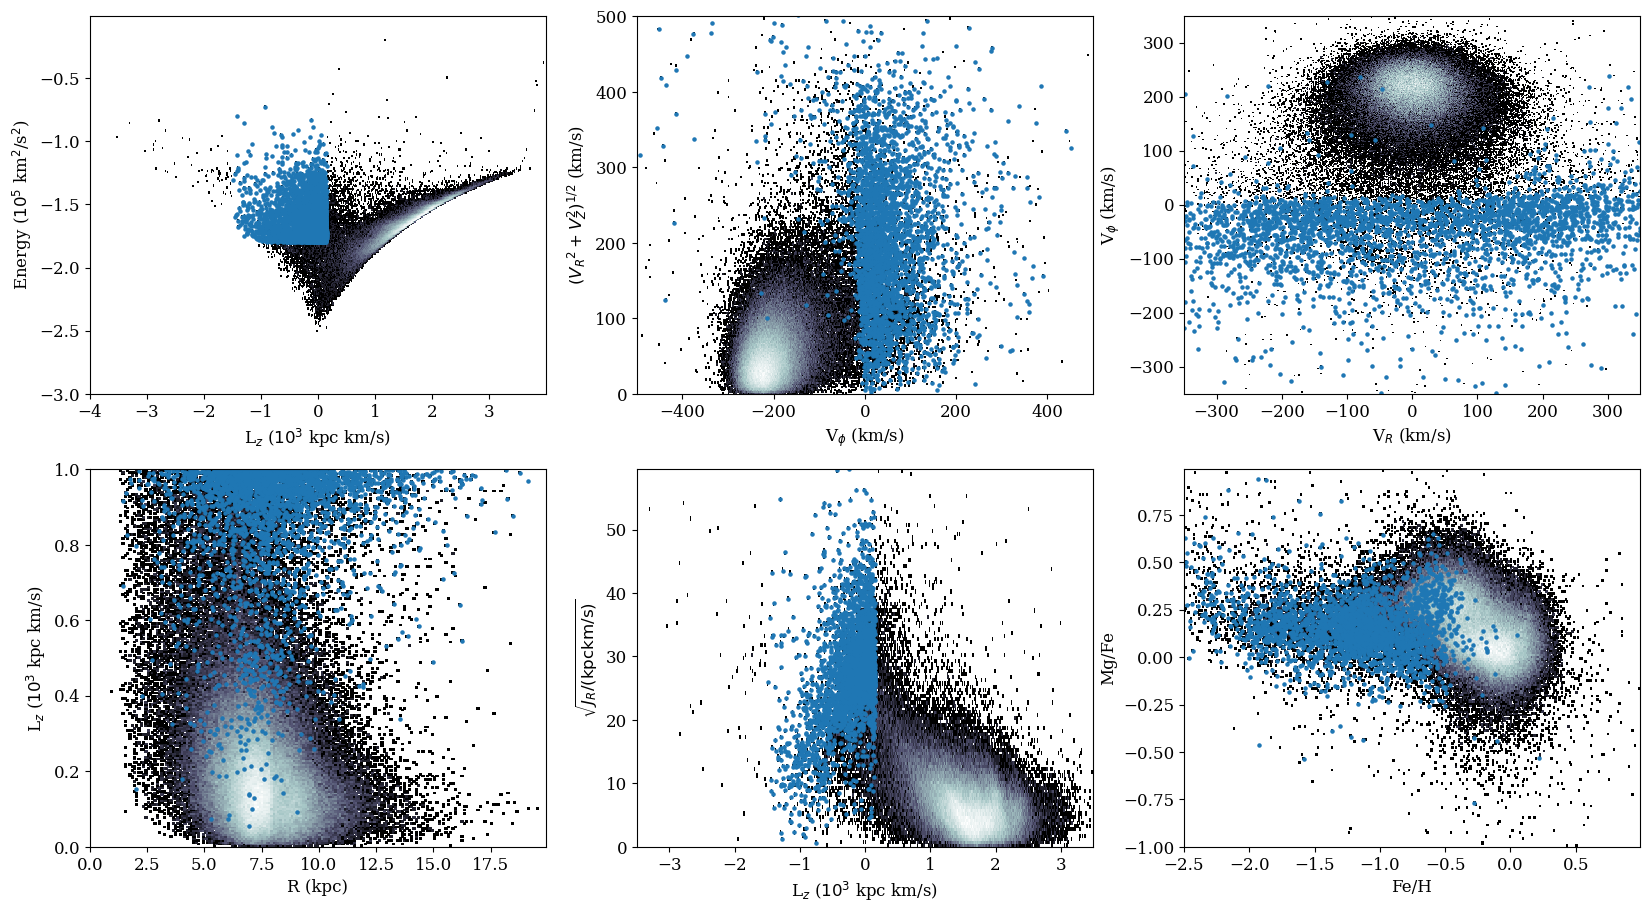

In [126]:
#Same plots as above, but overplotting stars using the Helmi selection. 
f, ax=plt.subplots(2,3, figsize=(20,11))

ax[0,0].hist2d(Lz/1000.,energy/1.e5, \
           bins=(np.arange(-4,4,.01), np.arange(-3., 0, 0.01)), norm=LogNorm(), cmap='bone');
ax[0,0].set_ylabel(r"Energy ($10^5$ km$^2$/s$^2$)")
ax[0,0].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[0,0].scatter(Lz[helmi]/1000.,energy[helmi]/1.e5, s=5)

ax[0,1].hist2d(vphi.value, vRz.value,\
           bins=(np.arange(-500, 500+1e-3, 2),
                np.arange(0, 500+1e-3, 2)),
          norm=LogNorm(), cmap='bone');
ax[0,1].set_xlabel(r'V$_{\phi}$ (km/s)')
ax[0,1].set_ylabel(r'$(V{_R}^2+V_Z^2)^{1/2}$ (km/s)')
ax[0,1].scatter(vphi.value[helmi], vRz.value[helmi], s=5)

ax[0,2].hist2d(Vr,Vphi, bins=np.arange(-350,350), norm=LogNorm(), cmap='bone');
ax[0,2].set_ylabel(r'V$_{\phi}$ (km/s)')
ax[0,2].set_xlabel('V$_{R}$ (km/s)')
ax[0,2].scatter(Vr[helmi],Vphi[helmi], s=5)

ax[1,0].hist2d(r,ecc, bins=(np.arange(0,20,0.1), np.arange(0,1.001,0.005)), norm=LogNorm(), cmap='bone');
ax[1,0].set_xlabel('R (kpc)')
ax[1,0].set_ylabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,0].scatter(r[helmi],ecc[helmi],s=5)

ax[1,1].hist2d(Lz/1000.,np.sqrt(Jr),  bins=(np.arange(-3.5,3.5,.01),np.arange(0,60,0.5)), norm=LogNorm(), cmap='bone');
ax[1,1].set_ylabel(r'$\sqrt{J_R/(\mathrm{kpc km/s})}$')
ax[1,1].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,1].scatter(Lz[helmi]/1000.,np.sqrt(Jr[helmi]),s=5)


ax[1,2].hist2d(full_tab['fe_h'][giants&keep],full_tab['Mg_fe'][giants&keep], \
           bins=(np.arange(-2.5, 1.0, 0.01), np.arange(-1,1, 0.01)), norm=LogNorm(), cmap='bone');
ax[1,2].set_ylabel('Mg/Fe')
ax[1,2].set_xlabel('Fe/H')
ax[1,2].scatter(full_tab['fe_h'][giants&keep][helmi],full_tab['Mg_fe'][giants&keep][helmi], s=5)


plt.subplots_adjust()

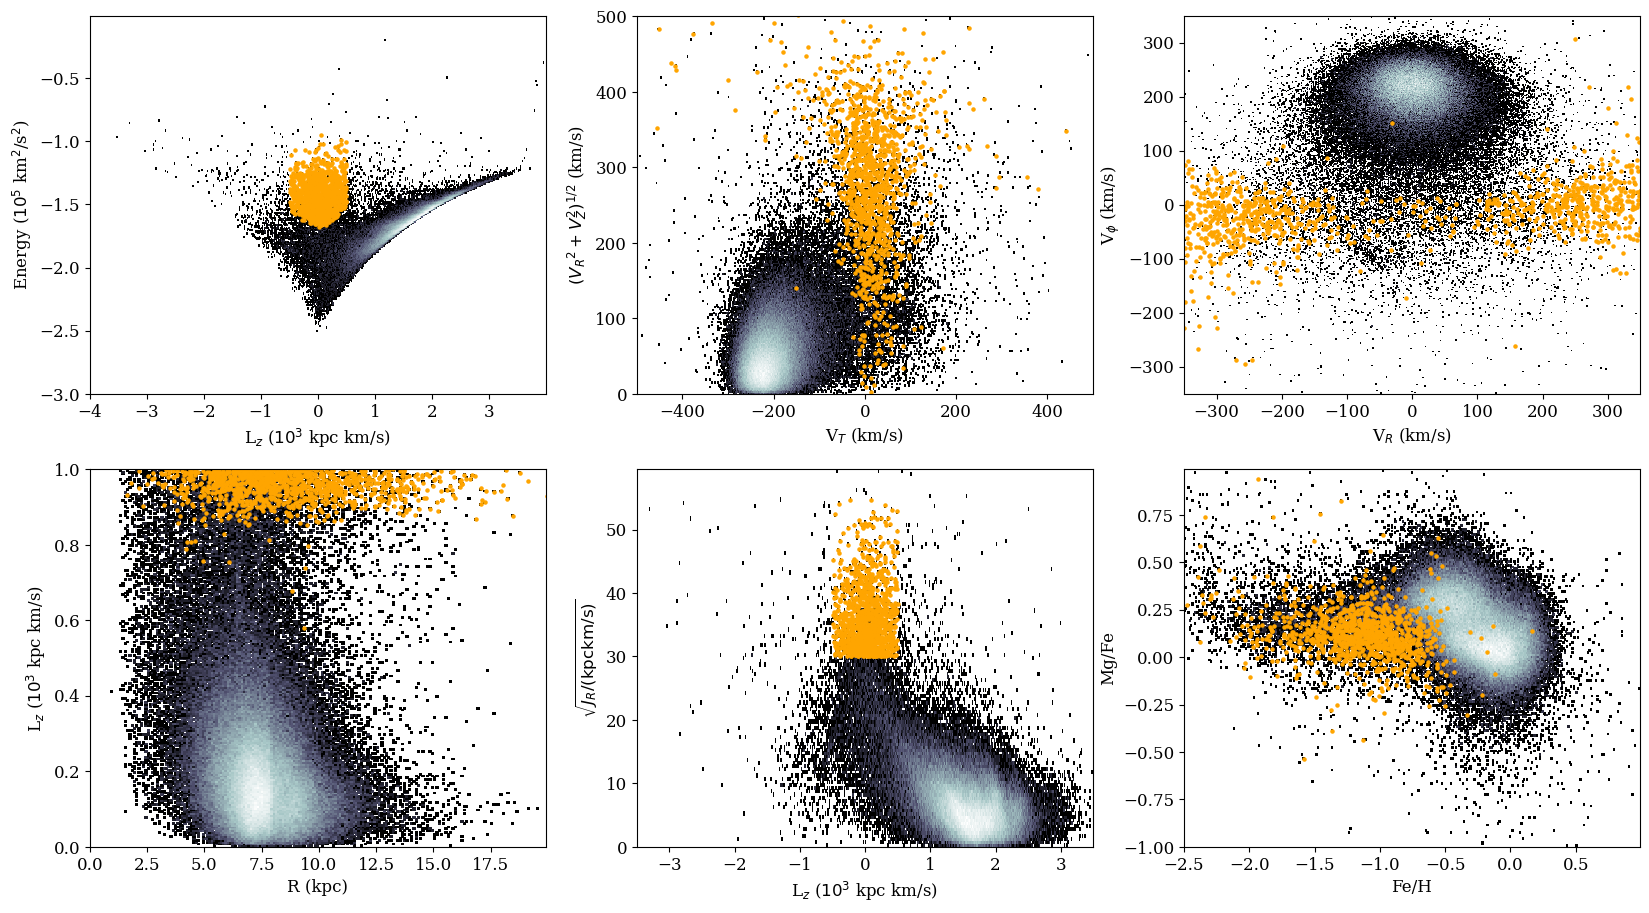

In [122]:
#Same plots as above, but for the Feuillet selection. 

f, ax=plt.subplots(2,3, figsize=(20,11))

ax[0,0].hist2d(Lz/1000.,energy/1.e5, \
           bins=(np.arange(-4,4,.01), np.arange(-3., 0, 0.01)), norm=LogNorm(), cmap='bone');
ax[0,0].set_ylabel(r"Energy ($10^5$ km$^2$/s$^2$)")
ax[0,0].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[0,0].scatter(Lz[feuillet]/1000.,energy[feuillet]/1.e5, s=5, c='orange')

ax[0,1].hist2d(vphi.value, vRz.value,\
           bins=(np.arange(-500, 500+1e-3, 2),
                np.arange(0, 500+1e-3, 2)),
          norm=LogNorm(), cmap='bone');
ax[0,1].set_xlabel(r'V${_T}$ (km/s)')
ax[0,1].set_ylabel(r'$(V{_R}^2+V_Z^2)^{1/2}$ (km/s)')
ax[0,1].scatter(vphi.value[feuillet], vRz.value[feuillet], s=5, c='orange')

ax[0,2].hist2d(Vr,Vphi, bins=np.arange(-350,350), norm=LogNorm(), cmap='bone');
ax[0,2].set_ylabel(r'V$_{\phi}$ (km/s)')
ax[0,2].set_xlabel('V$_{R}$ (km/s)')
ax[0,2].scatter(Vr[feuillet],Vphi[feuillet], s=5, c='orange')

ax[1,0].hist2d(r,ecc, bins=(np.arange(0,20,0.1), np.arange(0,1.001,0.005)), norm=LogNorm(), cmap='bone');
ax[1,0].set_xlabel('R (kpc)')
ax[1,0].set_ylabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,0].scatter(r[feuillet],ecc[feuillet],s=5, c='orange')

ax[1,1].hist2d(Lz/1000.,np.sqrt(Jr),  bins=(np.arange(-3.5,3.5,.01),np.arange(0,60,0.5)), norm=LogNorm(), cmap='bone');
ax[1,1].set_ylabel(r'$\sqrt{J_R/(\mathrm{kpc km/s})}$')
ax[1,1].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,1].scatter(Lz[feuillet]/1000.,np.sqrt(Jr[feuillet]),s=5, c='orange')


ax[1,2].hist2d(full_tab['fe_h'][giants&keep],full_tab['Mg_fe'][giants&keep], \
           bins=(np.arange(-2.5, 1.0, 0.01), np.arange(-1,1, 0.01)), norm=LogNorm(), cmap='bone');
ax[1,2].set_ylabel('Mg/Fe')
ax[1,2].set_xlabel('Fe/H')
ax[1,2].scatter(full_tab['fe_h'][giants&keep][feuillet],full_tab['Mg_fe'][giants&keep][feuillet], s=5, c='orange')


plt.subplots_adjust()

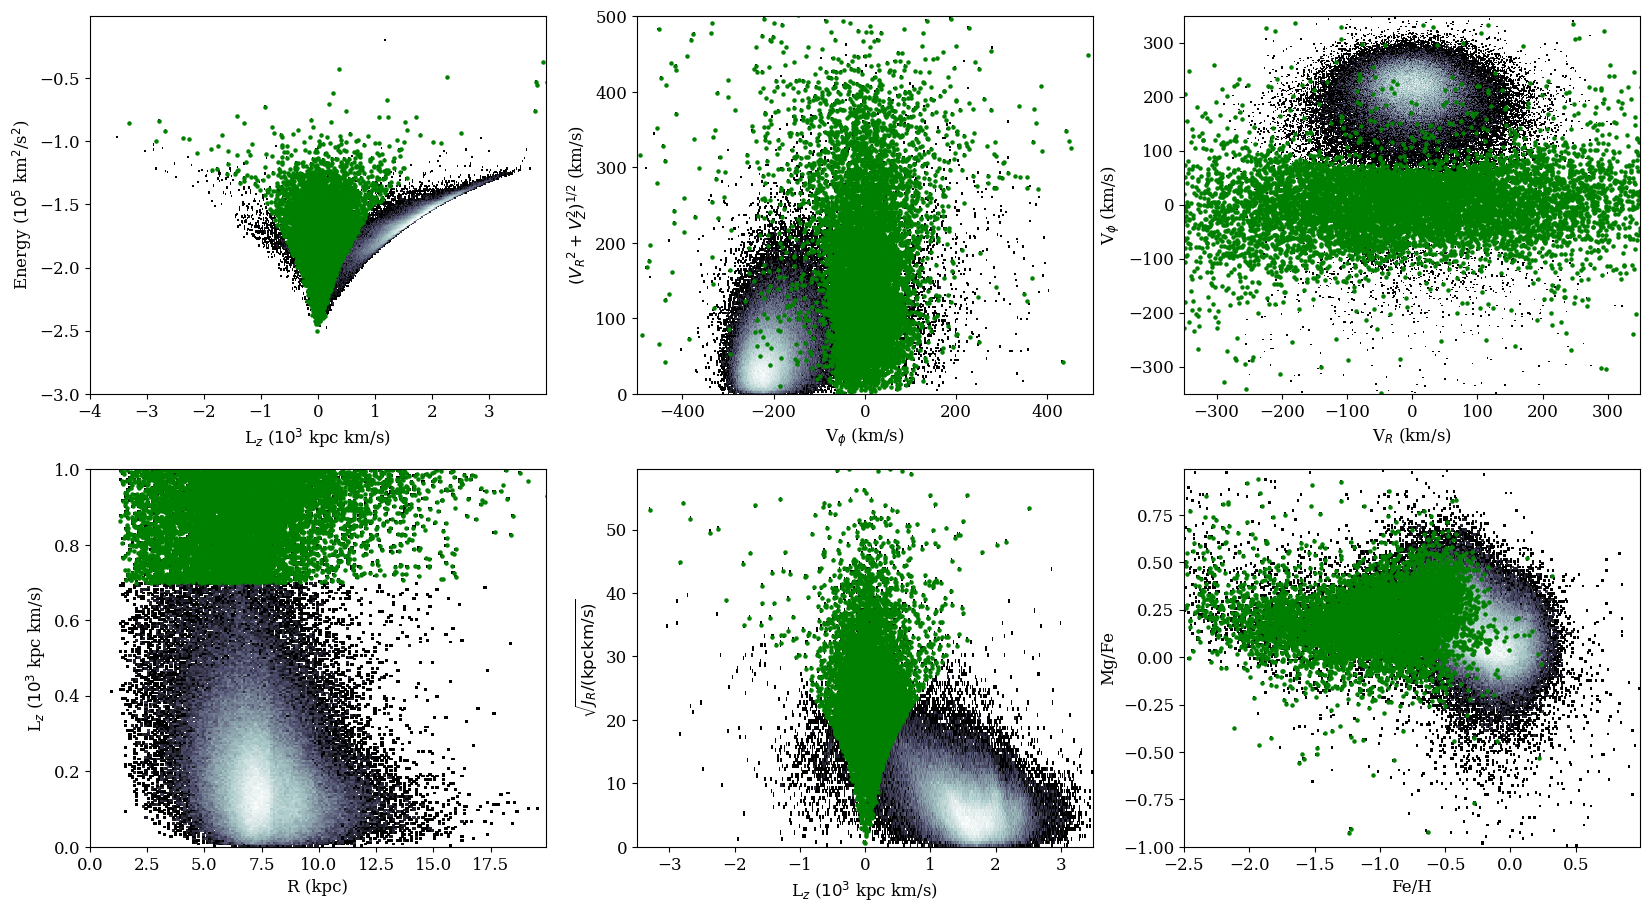

In [127]:
#Finally, for the Naidu selection
f, ax=plt.subplots(2,3, figsize=(20,11))

ax[0,0].hist2d(Lz/1000.,energy/1.e5, \
           bins=(np.arange(-4,4,.01), np.arange(-3., 0, 0.01)), norm=LogNorm(), cmap='bone');
ax[0,0].set_ylabel(r"Energy ($10^5$ km$^2$/s$^2$)")
ax[0,0].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[0,0].scatter(Lz[naidu]/1000.,energy[naidu]/1.e5, s=5, c='green')

ax[0,1].hist2d(vphi.value, vRz.value,\
           bins=(np.arange(-500, 500+1e-3, 2),
                np.arange(0, 500+1e-3, 2)),
          norm=LogNorm(), cmap='bone');
ax[0,1].set_xlabel(r'V$_{\phi}$ (km/s)')
ax[0,1].set_ylabel(r'$(V{_R}^2+V_Z^2)^{1/2}$ (km/s)')
ax[0,1].scatter(vphi.value[naidu], vRz.value[naidu], s=5,c='green')

ax[0,2].hist2d(Vr,Vphi, bins=np.arange(-350,350), norm=LogNorm(), cmap='bone');
ax[0,2].set_ylabel(r'V$_{\phi}$ (km/s)')
ax[0,2].set_xlabel('V$_{R}$ (km/s)')
ax[0,2].scatter(Vr[naidu],Vphi[naidu], s=5, c='green')

ax[1,0].hist2d(r,ecc, bins=(np.arange(0,20,0.1), np.arange(0,1.001,0.005)), norm=LogNorm(), cmap='bone');
ax[1,0].set_xlabel('R (kpc)')
ax[1,0].set_ylabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,0].scatter(r[naidu],ecc[naidu],s=5, c='green')

ax[1,1].hist2d(Lz/1000.,np.sqrt(Jr),  bins=(np.arange(-3.5,3.5,.01),np.arange(0,60,0.5)), norm=LogNorm(), cmap='bone');
ax[1,1].set_ylabel(r'$\sqrt{J_R/(\mathrm{kpc km/s})}$')
ax[1,1].set_xlabel(r"L$_z$ ($10^3$ kpc km/s)")
ax[1,1].scatter(Lz[naidu]/1000.,np.sqrt(Jr[naidu]),s=5, c='green')


ax[1,2].hist2d(full_tab['fe_h'][giants&keep],full_tab['Mg_fe'][giants&keep], \
           bins=(np.arange(-2.5, 1.0, 0.01), np.arange(-1,1, 0.01)), norm=LogNorm(), cmap='bone');
ax[1,2].set_ylabel('Mg/Fe')
ax[1,2].set_xlabel('Fe/H')
ax[1,2].scatter(full_tab['fe_h'][giants&keep][naidu],full_tab['Mg_fe'][giants&keep][naidu], s=5, c='green')


plt.subplots_adjust()

With these different samples, there are a few questions we can explore:

1. Is the GES a retrograde structure? How does the answer to this question change given the different selections?

2. What do the velocity distributios look like with the different selections? 

3. What is are the chemical properties of the GES? Do the different studies agree? Play with a few of the many abundances GALAH has to offer! 

If you have time: try remaking the above plots with a chemically selected halo (e.g., $[Fe/H]<-1.0$). What are the kinematic properties of this sample? Can you see the GES? Do its properties agree with the different kinematic-based selections?